In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
ab1 = np.load("../input/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../input/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../input/image-colorization/ab/ab/ab3.npy")
l = np.load("../input/image-colorization/l/gray_scale.npy")

In [3]:
ab = np.concatenate([ab1, ab2, ab3], axis = 0)

In [4]:
print(ab.shape, l.shape)

(25000, 224, 224, 2) (25000, 224, 224)


Taking only 500 images for training and 300 for testing (As we're only doing experimentation for now)

In [5]:
l_train = l[:500,:,:].astype("float32").reshape(500,l.shape[1],l.shape[2])
l_test = l[500:800,:,:].astype("float32").reshape(300,l.shape[1],l.shape[2])
ab_train = ab[:500,:,:].astype("float32")
ab_test = ab[500:800,:,:].astype("float32")
print(l_train.shape, ab_train.shape, l_test.shape, ab_test.shape)

(500, 224, 224) (500, 224, 224, 2) (300, 224, 224) (300, 224, 224, 2)


In [6]:
#converting gray scale img of 1 channel to b&w img of 3 channels
import tensorflow as tf
def line_image(gray_images,count):
    i = 0
    Zeros_Imp = np.zeros((count,224,224,3))
    for gray_img in gray_images:
        backtorgb = cv2.cvtColor(gray_img,cv2.COLOR_GRAY2RGB)
        Zeros_Imp[i] = backtorgb
        i+=1
        
    return Zeros_Imp



In [7]:
input_images = line_image(l_train,500)
X_train = input_images
print(X_train.shape)

(500, 224, 224, 3)


In [8]:
test_input = line_image(l_test, 300)
X_test = test_input
print(X_test.shape)

(300, 224, 224, 3)


In [9]:
# converting y_train and y_test from LAB to RGB
import cv2
# def from_lab_to_rgb(gray_images,ab_images,n):
#     Zeros_Imp = np.zeros((n,224,224,3))
    
#     Zeros_Imp[:,:,:,0] = gray_images[0:n:]
#     Zeros_Imp[:,:,:,1:] = ab_images[0:n:]
    
#     Zeros_Imp = Zeros_Imp.astype("uint8")
    
#     Main_Img = []
    
#     for indexing in range(0,n):
#         Main_Img.append(cv2.cvtColor(Zeros_Imp[indexing],cv2.COLOR_LAB2RGB))
        
#     Main_Img = np.array(Main_Img)
    
#     return Main_Img

y_train = np.zeros(shape=(500,224,224,3))
for indexing in range(len(ab_train)):
    y_train[:,:,:,0][indexing] = l_train[:,:,:][indexing]
    y_train[:,:,:,1:][indexing] = ab_train[:,:,:,:][indexing]
y_train = y_train.astype("uint8")
y_train.shape

(500, 224, 224, 3)

In [10]:
y_test = np.zeros(shape=(300,224,224,3))
for indexing in range(len(ab_test)):
    y_test[:,:,:,0][indexing] = l_test[:,:,:][indexing]
    y_test[:,:,:,1:][indexing] = ab_test[:,:,:,:][indexing]
y_test = y_test.astype("uint8")
y_test.shape

(300, 224, 224, 3)

In [11]:
arr = []
    
for indexing in range(0,500):
    arr.append(cv2.cvtColor(y_train[indexing],cv2.COLOR_LAB2RGB))

y_train = np.array(arr)

In [12]:
arr = []
    
for indexing in range(0,300):
    arr.append(cv2.cvtColor(y_test[indexing],cv2.COLOR_LAB2RGB))

y_test = np.array(arr)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(500, 224, 224, 3)
(500, 224, 224, 3)
(300, 224, 224, 3)
(300, 224, 224, 3)


In [14]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


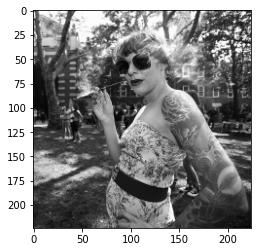

In [15]:
X_train = X_train.astype("uint8")
plt.imshow(X_train[0])

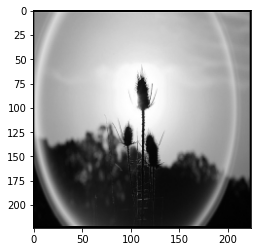

In [16]:
X_test = X_test.astype("uint8")
plt.imshow(X_test[0])

(224, 224, 3)


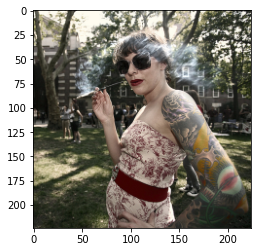

In [17]:
plt.imshow(y_train[0])
print(y_train[0].shape)

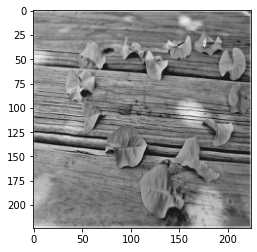

In [18]:
plt.imshow(X_train[1])

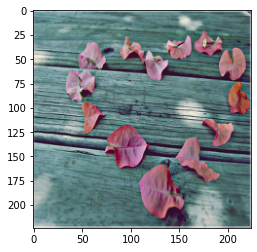

In [19]:
plt.imshow(y_train[1])

# Data is ready, Building Model

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential

In [21]:
Encoder_G = Sequential()
Encoder_G.add(layers.Conv2D(32,(2,2),input_shape=[224,224,3], kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(layers.BatchNormalization())
Encoder_G.add(layers.ReLU())
#
Encoder_G.add(layers.Conv2D(64,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(layers.BatchNormalization())
Encoder_G.add(layers.ReLU())
#
Encoder_G.add(layers.Conv2D(128,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(layers.BatchNormalization())
Encoder_G.add(layers.ReLU())

Encoder_G.add(layers.Conv2D(256,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_G.add(layers.BatchNormalization())
Encoder_G.add(layers.ReLU())


Decoder_G = Sequential()
Decoder_G.add(layers.Conv2DTranspose(128,(2,2),padding = "same",use_bias = True))
Decoder_G.add(layers.ReLU())
#
Decoder_G.add(layers.Conv2DTranspose(64,(2,2),padding = "same",use_bias = True))
Decoder_G.add(layers.ReLU())
#
Decoder_G.add(layers.Conv2DTranspose(32,(2,2),padding = "same",use_bias = True))
Decoder_G.add(layers.ReLU())
#
Decoder_G.add(layers.Conv2DTranspose(3,(2,2),padding = "same",use_bias = True))
Decoder_G.add(layers.ReLU())

2022-09-02 12:25:42.214488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 12:25:42.374338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 12:25:42.378163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 12:25:42.383157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [22]:
Auto_Encoder = Sequential([Encoder_G,Decoder_G])

In [23]:
compile_loss = "mse"
compile_optimizer = keras.optimizers.RMSprop(learning_rate=0.0001,decay=1e-8)
compile_metrics = ["accuracy"]
input_dim = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
output_class = 1

In [24]:
Auto_Encoder.compile(loss=compile_loss,optimizer=compile_optimizer,metrics=compile_metrics)

In [25]:
Auto_Encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 256)     174816    
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       172643    
Total params: 347,459
Trainable params: 346,499
Non-trainable params: 960
_________________________________________________________________


In [26]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [27]:
Auto_Encoder_Model = Auto_Encoder.fit(X_train,y_train,epochs=25,callbacks=[Early_Stopper,Checkpoint_Model],batch_size=16)

2022-09-02 12:25:46.660103: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75264000 exceeds 10% of free system memory.
2022-09-02 12:25:46.769891: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75264000 exceeds 10% of free system memory.
2022-09-02 12:25:46.920240: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75264000 exceeds 10% of free system memory.
2022-09-02 12:25:46.993874: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 75264000 exceeds 10% of free system memory.
2022-09-02 12:25:47.103918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-09-02 12:25:50.162259: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 21s 343ms/step - loss: 11517.7920 - accuracy: 0.5986
Epoch 2/25
32/32 [==============================] - 11s 334ms/step - loss: 4398.5225 - accuracy: 0.5994
Epoch 3/25
32/32 [==============================] - 11s 332ms/step - loss: 1851.9520 - accuracy: 0.5930
Epoch 4/25
32/32 [==============================] - 11s 333ms/step - loss: 1195.9930 - accuracy: 0.5927
Epoch 5/25
32/32 [==============================] - 11s 334ms/step - loss: 1117.3607 - accuracy: 0.5864
Epoch 6/25
32/32 [==============================] - 11s 332ms/step - loss: 1138.6995 - accuracy: 0.5838
Epoch 7/25
32/32 [==============================] - 11s 332ms/step - loss: 1095.5500 - accuracy: 0.5839
Epoch 8/25
32/32 [==============================] - 11s 333ms/step - loss: 1075.1104 - accuracy: 0.5871
Epoch 9/25
32/32 [==============================] - 11s 332ms/step - loss: 1090.0563 - accuracy: 0.5890
Epoch 10/25
32/32 [==============================] - 11s 333ms/step - loss

# Predictions

In [29]:
predictions = Auto_Encoder.predict(X_test[0:10])

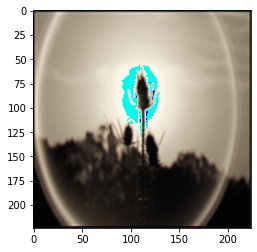

In [32]:
predictions = predictions.astype("uint8")
plt.imshow(predictions[0])

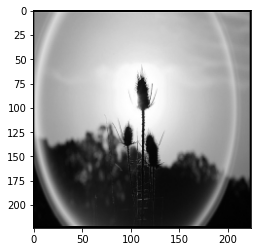

In [33]:
plt.imshow(X_test[0])

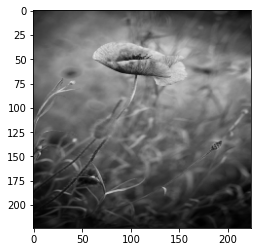

In [37]:
plt.imshow(X_test[1])

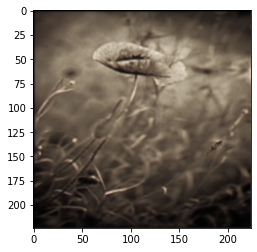

In [38]:
plt.imshow(predictions[1])

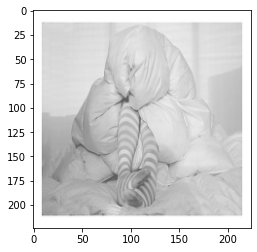

In [39]:
plt.imshow(X_test[2])

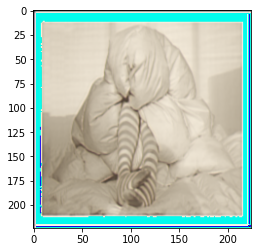

In [40]:
plt.imshow(predictions[2])

The colorizer works but extremely poorly.